# Met Office DataHub Exploration

---

DataHub is a service dedicated to giving pubic access to Met Office data. In this notebook we will progamatically download data from DataHub and explore it through visulisation techniques. 

### Prerequisites
To follow along with this notebook, an account for the DataHub service must be set up, more detail can be found on the DataHub website (and detail on the environment file is found below). A general overview of the steps that the reader may want to follow are:
* Create an account on DataHub 
* Choose the free pricing plan for both atmospheric and site specific services on DataHub to gain API key access
* Create desired atmospheric orders within the DataHub account (In this tutorial, a single-level (height level) single-parameter, and a multi-level single-parameter order is used)
* Place your required API information (order names + client secrets and ids) in environment variables.
    * More information on environment variables below

## Contents

- Download All Self-Defined Orders Using a Subprocess Call to the Provided DataHub Download File `cda_download.py`
- Explore DataHub Data
  - Single Level Atmospheric Plotting
    - With Xarray
    - With Iris
  - Multi Level Atmospheric Plotting
    - Load Data, Show Metadata
    - Single Layer Plot From Multi Level Data
    - Conversion of Units with Iris
    - Plotted Example of Desired vs Actual Closest Datapoint
    - Height Profile of Data at Fixed Latitude
    - Plot of Actual Datapoints in Gridded Data
      - Height Profile
      - Topdown
    - Show of Temperature at a Single Datapoint (Temperature Column)
  - Site Specific Data Exploration
    - Getting the Data (Current Site Specific Forecast for Exeter)
    - Plotting Two Temperatures (Feels Like, and Screen Temperature) from the Returned Data over the Entire Returned Forecast (Daylong Hourly Forecast)

## Part 1: DataHub Data Retrieval 

The first step to interacting with data, is creating access to the data. This is done through setting up the notebook with tools that can interact with the data (importing modules), and placing the data in a directory that the notebook has knowledge of.

In [1]:
# import required packages
import glob
import json
import subprocess
import requests

import cartopy.crs as ccrs
import cfgrib
import iris
import iris.quickplot as qplt
import iris_grib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# clear cell outputs when private API keys are displayed
from IPython.display import clear_output

Settings for the notebook are also defined, e.g. displaying the environment variables that have been read in may be useful for understanding, but is not a desirable quality of a working publicly hosted tutorial

In [2]:
# define notebook settings
HIDE_SECRET_OUTPUT = True  # clears cell output anytime an API key is shown

# displays the full return of a site specific request json
SHOW_SITE_JSON_REQUEST_DATA = False

For this notebook, a .env file is defined in order to abstract away keys personal to the user. The .env file is kept in the same directory as this notebook. Here is an example of what the .env file looks like:

```
ATMOSPHERIC_CLIENT_ID=xxxxxxxxxxxxxxxxxxxxxx
ATMOSPHERIC_CLIENT_SECRET=xxxxxxxxxxxxxxxxxxxxxx
SOME_OTHER_ENV_VAR=2gt2t1t2t7224pZ/*321
```

As shown, the format for each variable is ENV_VAR_NAME=ENV_SECRET with no spaces between the '=' and the definitions, or at the beginning of a line. A newline is required between each environment variable.
<br>Due to how the file is read without a the common tool `dotenv`, the .env file expects no comments, nor an in-file informational header. The names of each variable should be obvious.

In [3]:
# read environment file
env_vars = {}

with open(".env") as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars.keys())
print(env_vars.values())
if HIDE_SECRET_OUTPUT:
    clear_output()

In [4]:
# load environment variables for the notebook
ATMO_ID = env_vars["ATMOSPHERIC_CLIENT_ID"]
ATMO_SECRET = env_vars["ATMOSPHERIC_CLIENT_SECRET"]
SITE_ID = env_vars["SITE_SPECIFIC_CLIENT_ID"]
SITE_SECRET = env_vars["SITE_SPECIFIC_CLIENT_SECRET"]
MULTI_ORDER = env_vars["MULTI_LEVEL_ATMOSPHERIC_ORDER"]
SINGLE_ORDER = env_vars["SINGLE_LEVEL_ATMOSPHERIC_ORDER"]

## Download All Self-Defined Orders Using a Subprocess Call to the Provided DataHub Download File `cda_download.py`

To download from DataHub, define the necessary headers for the API call, then run subprocess for the cda_download file which is located in the same directory

In [5]:
# get the data from cda download
headers = {
    "X-IBM-Client-Id": ATMO_ID,
    "X-IBM-Client-Secret": ATMO_SECRET,
} #  the names in headers are the expected headers given to an actual GET request to Datahub

orders = [MULTI_ORDER, SINGLE_ORDER]  # my own orders, defined in env file
order_str = ""
for o in orders:
    order_str += o + ","
order_str = order_str[:-1]  # removes trailing ','

save_cda_directory = './data/DataHub/'

cda_headers = {
    "-u": "https://api-metoffice.apiconnect.ibmcloud.com/1.0.0",
    "-c": headers["X-IBM-Client-Id"],
    "-s": headers["X-IBM-Client-Secret"],
    "-o": order_str,
    "-l": save_cda_directory
} #  cda headers define the flags for a call to cda_download.py

In [6]:
# view runs available to each order with a GET request
request_results_list = []
for order in orders:
    request_url_string = cda_headers["-u"] + "/orders/" + order + "/latest"
    request = requests.get(request_url_string, headers=headers)
    request_results_list.append(request)

get all available requests (not just latest) with: <br>
`r = requests.get('https://api-metoffice.apiconnect.ibmcloud.com/1.0.0/runs?sort=RUN', headers=headers)`

In [7]:
# display the results of the run search
print("Response codes from requests:", request_results_list)

print("Response content:")
for r in request_results_list:
    content = r.json()
    order_details = content["orderDetails"]["order"]
    number_of_files_available = len(content["orderDetails"]["files"])
    print(json.dumps(order_details, indent=4))
    print("files:", json.dumps(number_of_files_available, indent=4), "\n")

Response codes from requests: [<Response [200]>, <Response [200]>]
Response content:
{
    "orderId": "o093919734016",
    "name": "O093919734016",
    "modelId": "mo-global",
    "format": "GRIB2"
}
files: 22 

{
    "orderId": "o154205129003",
    "name": "O154205129003",
    "modelId": "mo-uk",
    "format": "GRIB2"
}
files: 2 



In [8]:
# convert cda_headers to list inputtable to subprocess
cda_items = cda_headers.items()
cda_download_arguments = [item for tuples in cda_items for item in tuples]
print("Headers flattened:", cda_download_arguments)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [9]:
# concatenate all elements of the subprocess call into one list
python_script_arguments = ["python3", "cda_download.py"]
additional_flags = [
    "-d",  # -d = add a root directory with the date to the order downloads,
    "-v",  # -v = make the script verbose
]
subprocess_to_run = python_script_arguments + cda_download_arguments + additional_flags
print(subprocess_to_run)
if HIDE_SECRET_OUTPUT:
    clear_output()

example of equivalent command line usage of cda_download (replacing xxx...xxx with your own API keys / Order IDs + inserting a path to save to if desired):

```bash
$ python3 cda_download.py -u https://api-metoffice.apiconnect.ibmcloud.com/1.0.0 -c xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx -s xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx -o xxxxxxxxxxxxx -d -v
```

In [10]:
# run the subprocess
subprocess.run(subprocess_to_run)
print("\nSubprocess end!")
# on success, in the directory contains a folder 'downloaded' with orders

Download Orders
From the orders to process we have the following model list from active orders:  ['mo-global', 'mo-uk']
Processing: o093919734016
Plan and limit : name=free-plan,1000;
Remaining calls: name=free-plan,974;
    Starting downloads
    Total Files: 11 Total time taken: 25.11s Total Size: 1549757 Workers: 4

    Created summary: ./data/DataHub/results/summary-o093919734016-14-Sep-2022-13-24-57.txt
Processing: o154205129003
Plan and limit : name=free-plan,1000;
Remaining calls: name=free-plan,961;
    Starting downloads
    Total Files: 1 Total time taken: 0.74s Total Size: 436289 Workers: 4

    Created summary: ./data/DataHub/results/summary-o154205129003-14-Sep-2022-13-24-57.txt
All file downloads have been attempted.

Subprocess end!


## Explore Datahub Data

Glob is a tool that matches directories or files based on a given pattern. In this case, most of the directory pattern is defined by the directory pattern which cda_download.py defines for its saved files.
<br> There may be multiple files returned by this glob search, or likely just one: expect more files if you have run cda_download.py multiple times with large enough time intervals in-between to download new forecast data.

In [11]:
# get paths of downloaded files in downloaded folder
multi_path_pattern_str = (
    save_cda_directory #directory for saved data
    + 'downloaded/' #directory defined by cda_download
    +'*/' #directory that is timestamped by cda_download
    +MULTI_ORDER #orderID
    +'*/' #forecast reference for the order is appended to the orderID
    +'*.grib2' #desired filetype
)
single_path_pattern_str = (
    save_cda_directory 
    + 'downloaded/'
    +'*/'
    +SINGLE_ORDER 
    +'*/'
    +'*.grib2'
)
single_order_files = glob.glob(single_path_pattern_str)
print("Single level order data files:\n", single_order_files)
multi_order_files = glob.glob(multi_path_pattern_str)

Single level order data files:
 ['./data/DataHub/downloaded/202208171351_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208300943_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202209141325_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208311208_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208221136_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208191230_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208311707_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208311711_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202208311741_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/202209141108_00/o154205129003_00/agl_temperature_1.5_+00_0.grib2', './data/DataHub/downloaded/

In [12]:
# sort the glob return, so that the first file is the most recently downloaded.
single_order_files = sorted(single_order_files, reverse=True)
multi_order_files = sorted(multi_order_files, reverse=True)

## Part 2: Data Exploration

### Single level temperature plots

#### With Xarray

In [13]:
# load the most recent data file into an xarray dataset
ds = xr.open_dataset(single_order_files[0], engine="cfgrib")

In [14]:
# print xarray metadata
print(ds)

<xarray.Dataset>
Dimensions:            (y: 639, x: 455)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          5
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2022-09-14T13:25 GRIB to CDM+CF via cfgrib-0.9.1...


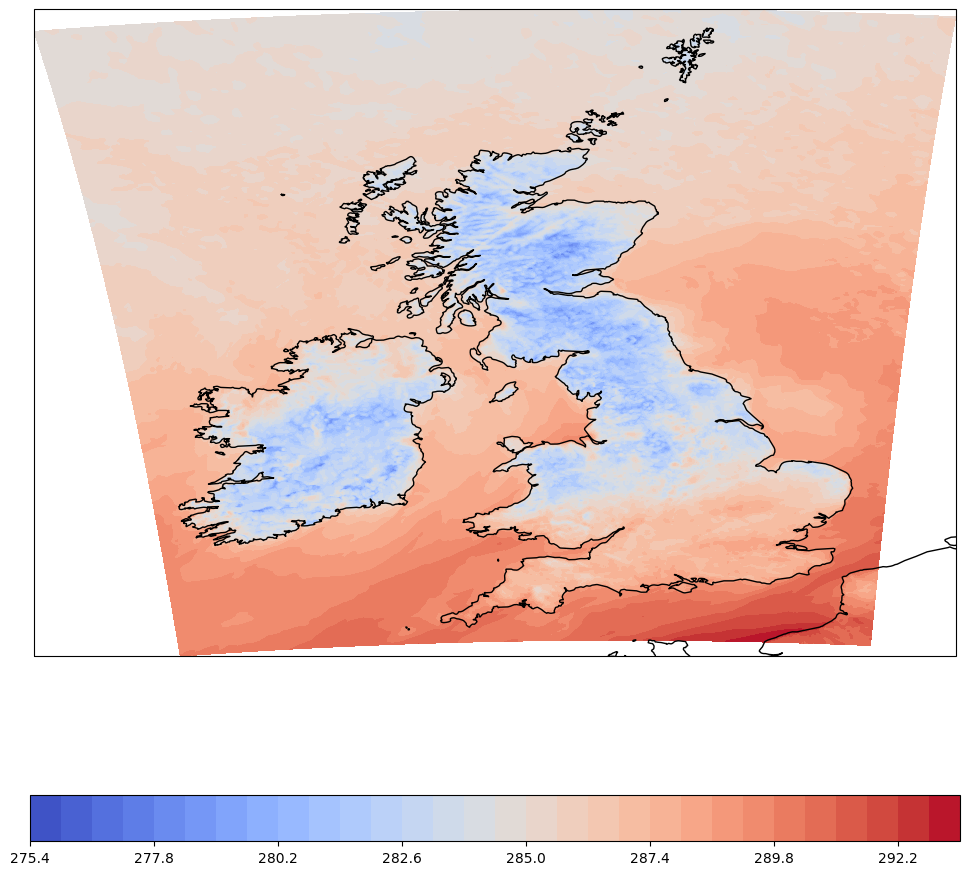

In [15]:
# plot the xarray data
proj = ccrs.PlateCarree()  # cartopy projection
fig = plt.figure(figsize=(12, 12))  # size of plot
axes = plt.axes(projection=proj)  # plot transform
ax = plt.contourf(
    ds["longitude"].data,
    ds["latitude"].data,
    ds["t2m"],  # temperature data
    transform=ccrs.PlateCarree(),  # data transform
    levels=30,  # number of contour bins
    cmap=plt.cm.coolwarm,  # color scheme for heatmap
)
plt.colorbar(location='bottom')
axes.coastlines()  # show maplines

#### With Iris

In [16]:
# load the cube in iris
iris_cubedata = iris.load_cubes(single_order_files[0])

In [17]:
# show metadata of the cubelist
iris_cubedata

[<iris 'Cube' of air_temperature / (K) (projection_y_coordinate: 639; projection_x_coordinate: 455)>]

In [18]:
# pick the temperature cube out of the loaded cubelist (only cube in the cubelist)
cube = iris_cubedata[0]

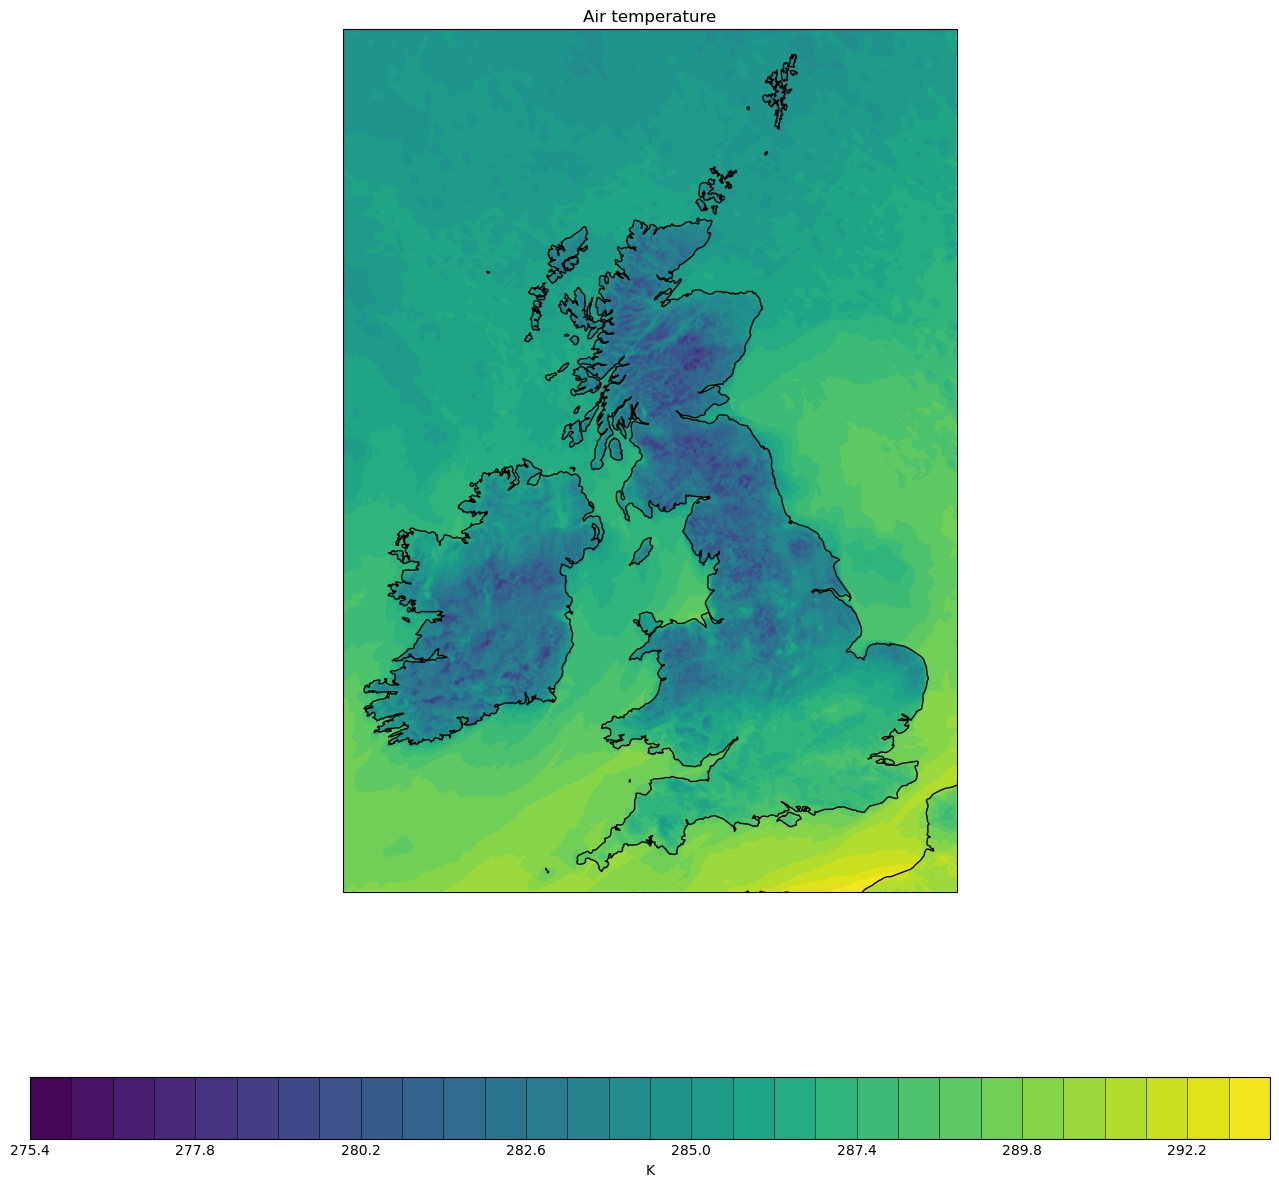

In [19]:
# plot the iris data
plt.figure(figsize=(16, 16))
qplt.contourf(cube, levels=30)
plt.gca().coastlines()  # different way of coastline display, as per iris documentation

plt.show()

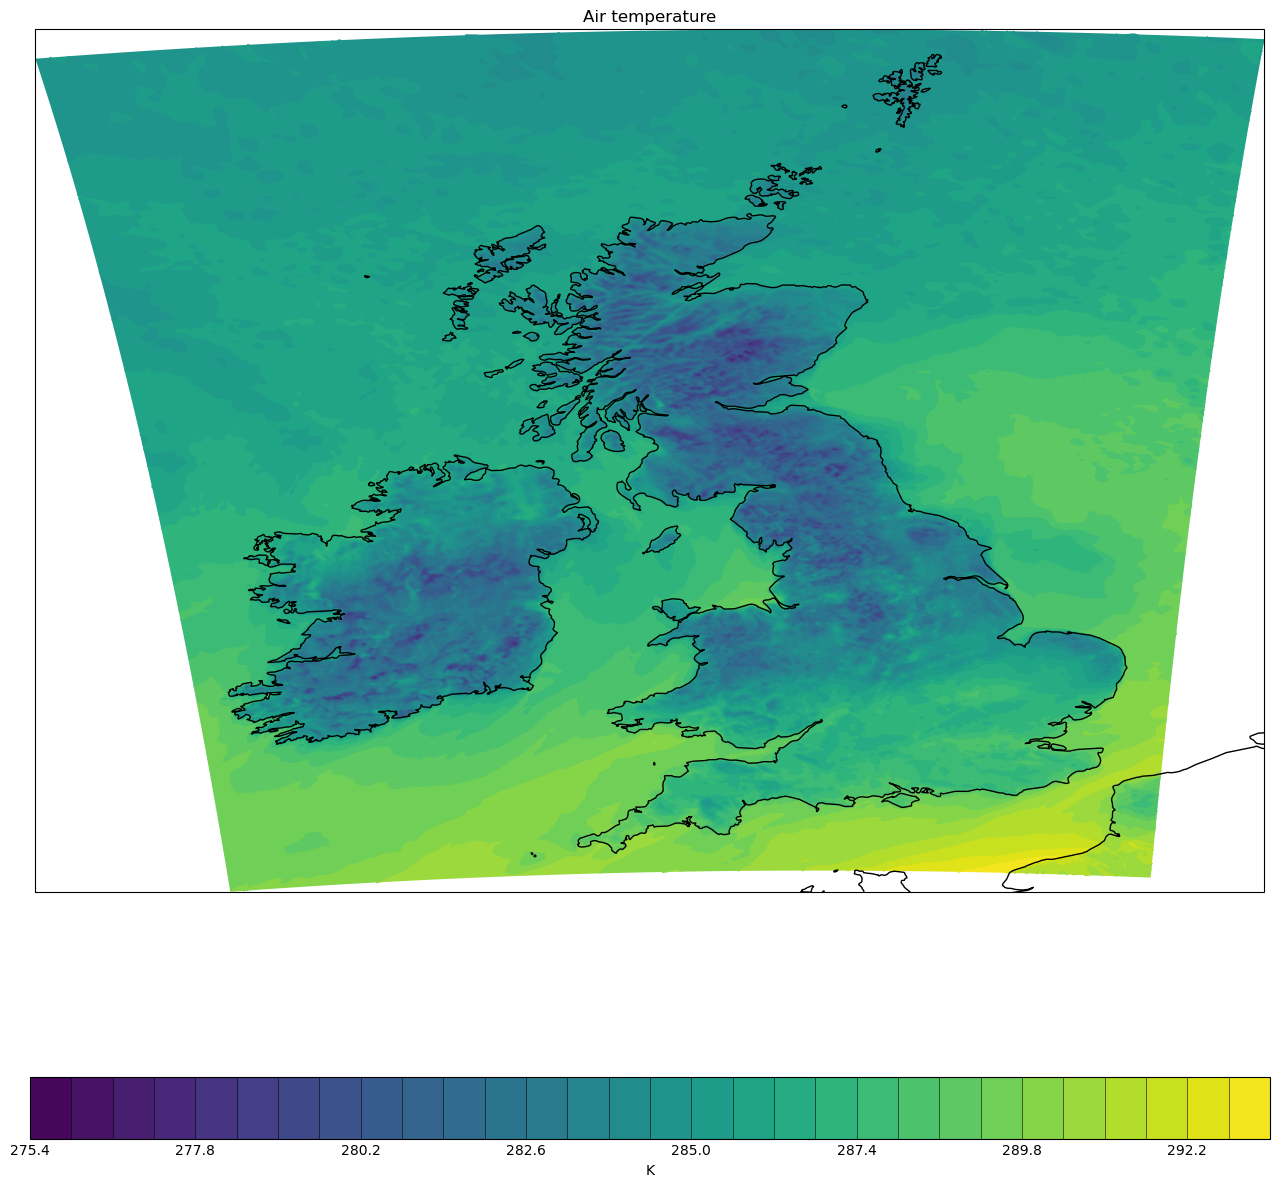

In [20]:
# or to mimic the plot generated by xarray, send the xarray data to iris
iris_cube_from_xarray = ds["t2m"].to_iris()
plt.figure(figsize=(16, 16))
qplt.contourf(iris_cube_from_xarray, levels=30)
plt.gca().coastlines()

plt.show()

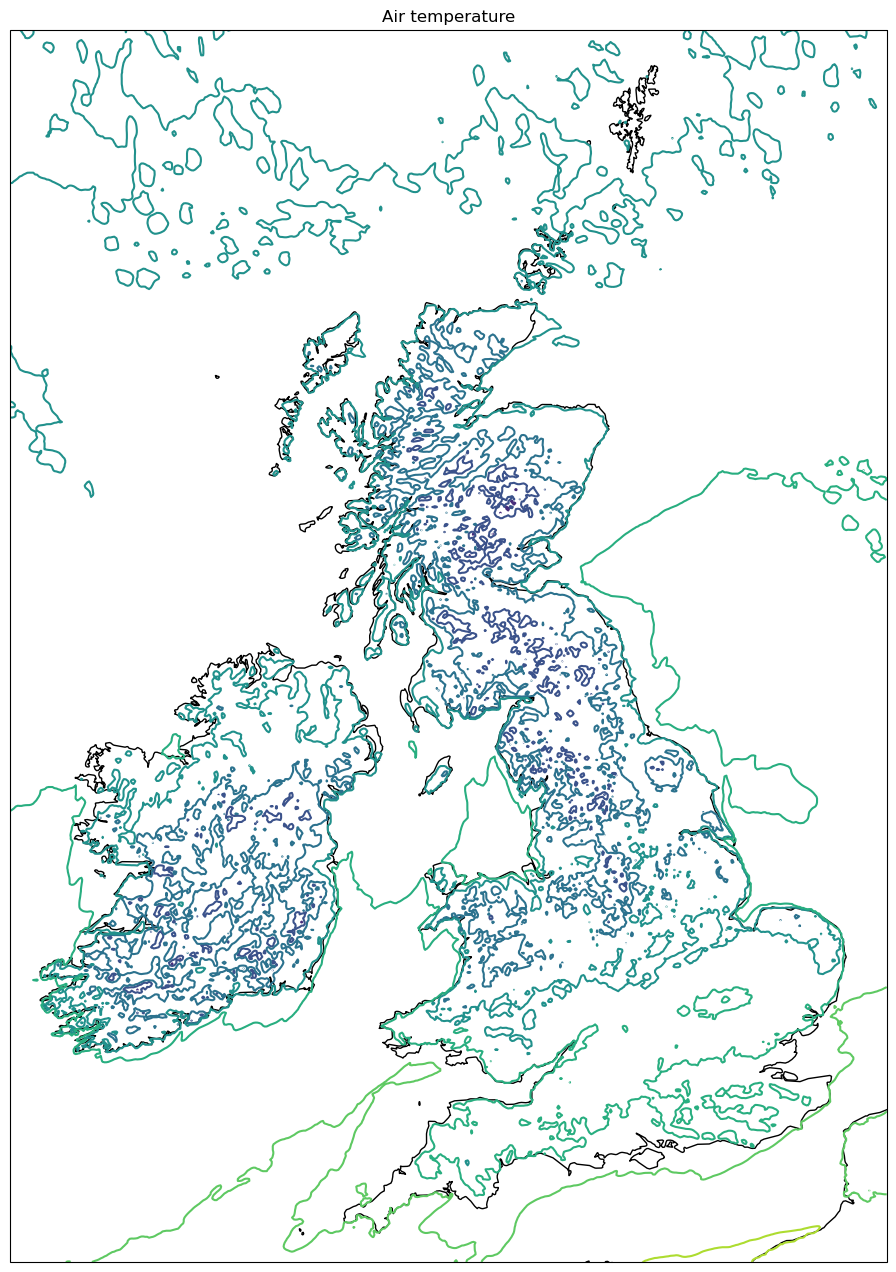

In [21]:
# show contour instead of contourf with iris
plt.figure(figsize=(16, 16))
qplt.contour(cube)
plt.gca().coastlines()
plt.show()

### Multi level Temperature Data

#### Load and Show Data

Multi level data is divided into multiple files, in the case of this order, one file for each height level, so all of the files must be loaded in and concatenated for a single cube. Luckily iris does this automatically when provided with a list of all files in one load statement.

In [22]:
#get only one download folders worth of data
#get the second last folder by finding second last occurence of /
single_multi_layer_file = multi_order_files[0]
index_of_last_folder = single_multi_layer_file.rfind('/')
single_multi_layer_dir = single_multi_layer_file[0:index_of_last_folder]
second_last_dir_index = single_multi_layer_dir.rfind('/')
most_recent_download_dir = single_multi_layer_file[0:second_last_dir_index]
most_recent_download_files = [most_recent_file for most_recent_file in multi_order_files if most_recent_file[0:second_last_dir_index] == most_recent_download_dir]

In [23]:
# load the paths in iris
all_data = iris.load_cubes(most_recent_download_files)
single_data = iris.load_cubes(most_recent_download_files[-1])

In [24]:
# the first and only cube in the produced iris cubelist will be the cube containing temperature data
all_data = all_data[0]  # convert cubelist to single cube
all_data

<iris 'Cube' of air_temperature / (K) (height: 11; time: 89; latitude: 24; longitude: 39)>

In [25]:
# do the same air temperature selection for the single level data
single_data = single_data[0]
single_data

<iris 'Cube' of air_temperature / (K) (time: 89; latitude: 24; longitude: 39)>

In [26]:
# get the coordinates in data for longitude and latitude
# data is the same for either cubelist
data_lat_values = single_data.coord("latitude").points
data_lon_values = single_data.coord("longitude").points
print("Lats:", data_lat_values)
print("Lons:", data_lon_values)

Lats: [49.453125 49.546875 49.640625 49.734375 49.828125 49.921875 50.015625
 50.109375 50.203125 50.296875 50.390625 50.484375 50.578125 50.671875
 50.765625 50.859375 50.953125 51.046875 51.140625 51.234375 51.328125
 51.421875 51.515625 51.609375]
Lons: [354.023438 354.164063 354.304688 354.445313 354.585938 354.726563
 354.867188 355.007813 355.148438 355.289063 355.429688 355.570313
 355.710938 355.851563 355.992188 356.132813 356.273438 356.414063
 356.554688 356.695313 356.835938 356.976563 357.117188 357.257813
 357.398438 357.539063 357.679688 357.820313 357.960938 358.101563
 358.242188 358.382813 358.523438 358.664063 358.804688 358.945313
 359.085938 359.226563 359.367188]


Files are seperated by height, and contain the selected area + another dimension for time

#### Single Layer Plot From Multi Level Data

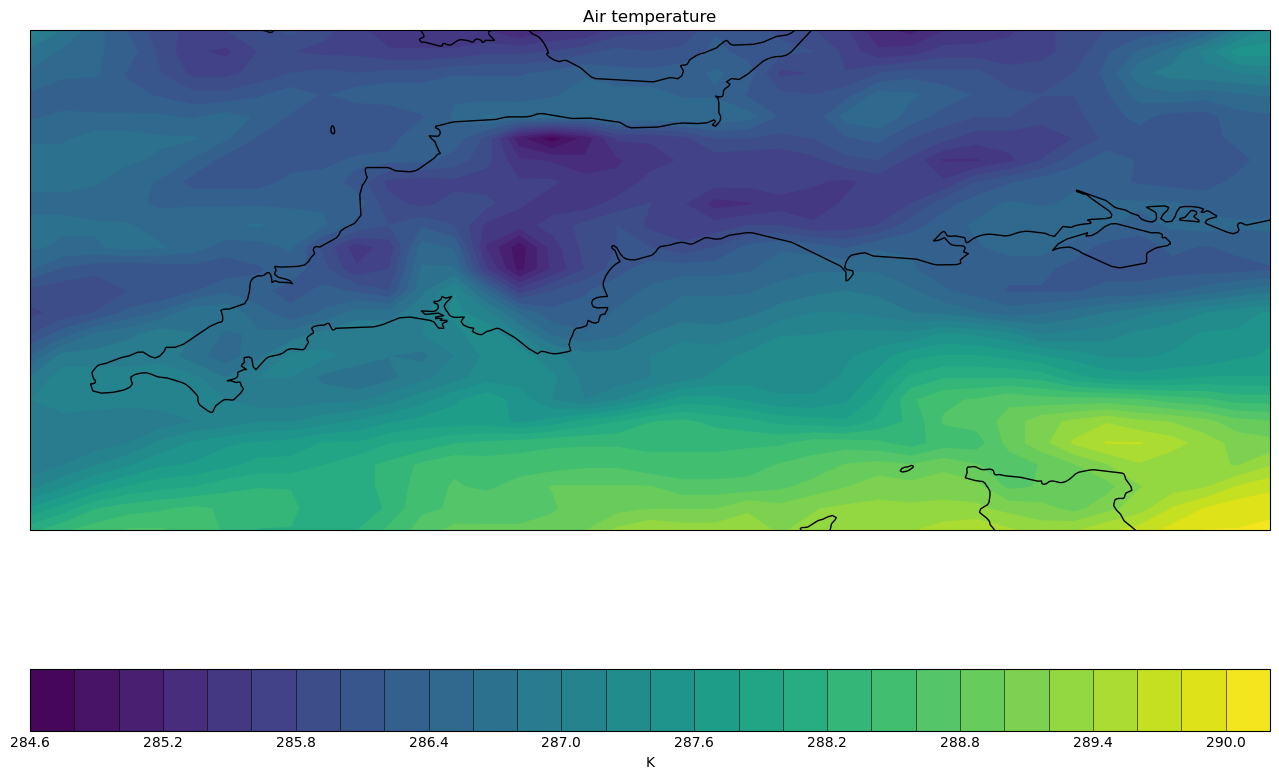

In [27]:
# single data can be treated just like our single layer data example, show a plot to example this
plt.figure(figsize=(16, 12))
# index like an array, get the first time value (since time is the first dimension in the dimension order)
qplt.contourf(single_data[0], levels=30)
plt.gca().coastlines()

plt.show()

#### Conversion of Units with Iris

Unit data: K


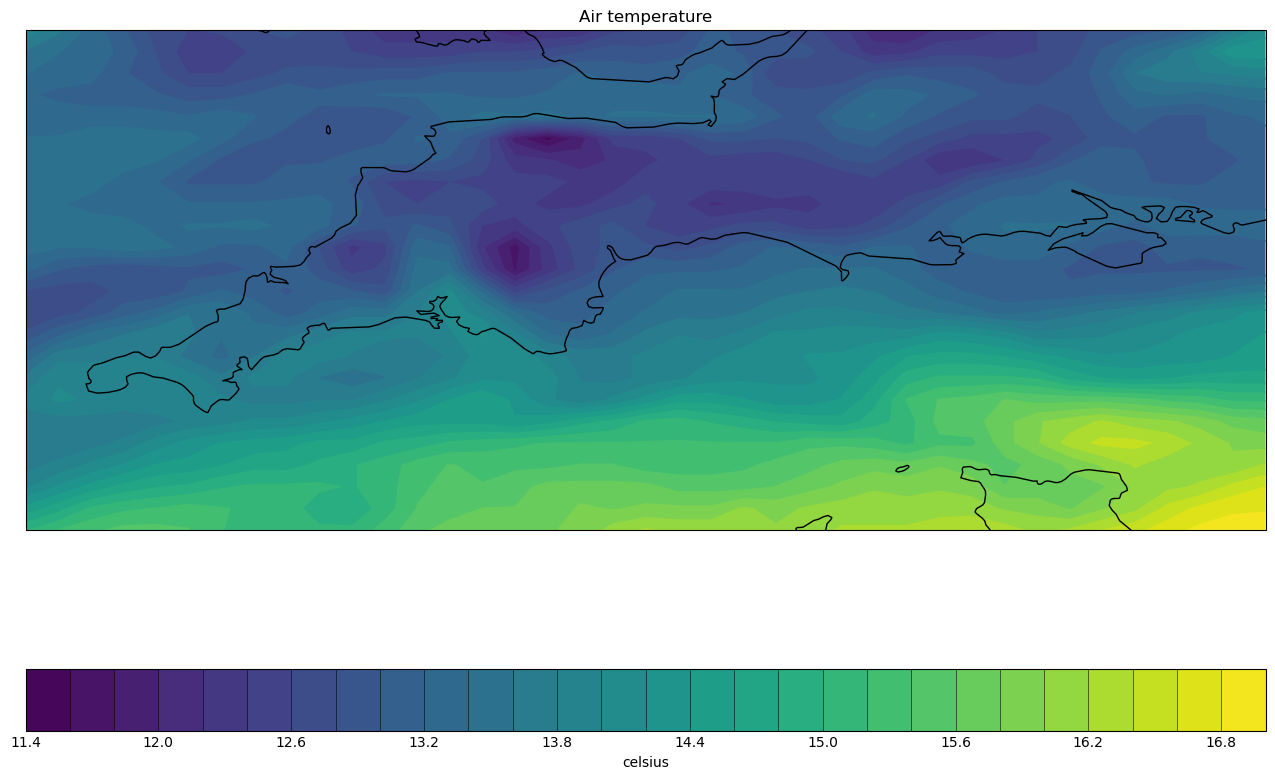

In [28]:
# iris supports conversion of units, replot with converted units (no change on plot except units on colorbar)
print("Unit data:", single_data.units)
cube_as_celcius = single_data
cube_as_celcius.convert_units(
    "celsius"
)  # iris conversion function, celcius and kelvin are known units
plt.figure(figsize=(16, 12))
qplt.contourf(cube_as_celcius[0], levels=30)
plt.gca().coastlines()

#### Plotted Example of Desired vs Actual Closest Datapoint

Closest lat val produced by model: 50.671875 vs desired: 50.716667


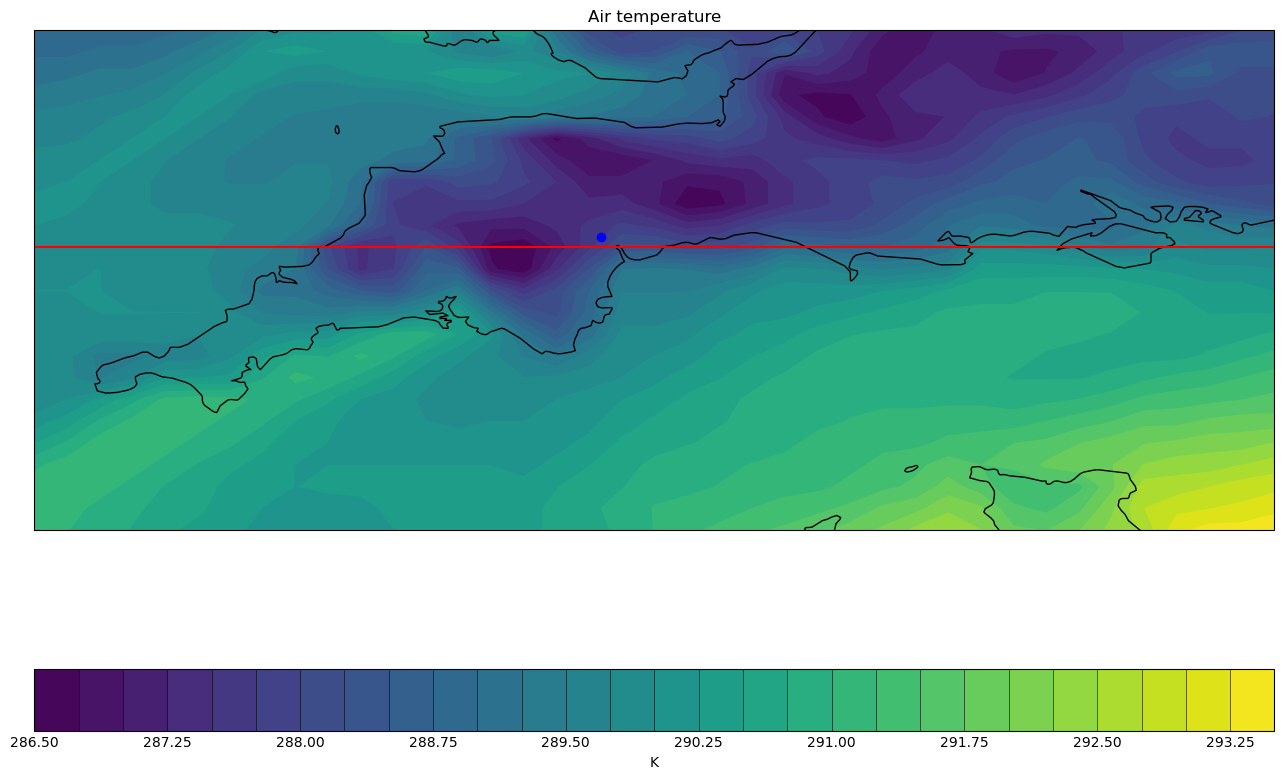

In [29]:
# show the same plot, but show a line of desired and actual latitude for later height profile
# to demonstrate the desired exact location typically doesn't exist at exactly a datapoint on the grid

multi_layer_cube_time_0_height_0 = all_data.extract(
    iris.Constraint(forecast_period=0)
).extract(iris.Constraint(height=np.min(all_data.coord("height").points)))

plt.figure(figsize=(16, 12))
# index like an array, first time value
qplt.contourf(multi_layer_cube_time_0_height_0, levels=30)
plt.gca().coastlines()

desired_lat = 50.716667
desired_lon = -3.533342
# in this example, the longitude doesn't have negative vals, so wrap the negative around the 360 degree
desired_lon_positive = 360 + desired_lon

# index of value closest to data_lat_values
index = np.abs(data_lat_values - desired_lat).argmin()
# closest value
closest_lat_val = data_lat_values[index]
print("Closest lat val produced by model:", closest_lat_val, "vs desired:", desired_lat)

plt.axhline(y=closest_lat_val, color="r", linestyle="-")
plt.plot(desired_lon, desired_lat, "bo")

plt.show()

#### Height Profile of Data at Fixed Latitude

instead of viewing the top-down view of the gridded data, we can have a look at the "height profile" of the data. This will be done by plotting the height against the longitude with a fixed latitude

In [30]:
# get the height profile at the previously plotted top-down red line
cube_sliced_by_time = all_data.slices(["height", "latitude", "longitude"])
cube_at_time_0 = cube_sliced_by_time.next()
print("cube at time 0:", cube_at_time_0)
# get the height profile with lat fixed near 50.716667 (EXETER)
height_profile_of_cube = cube_at_time_0.extract(
    iris.Constraint(latitude=closest_lat_val)
)

cube at time 0: air_temperature / (K)               (height: 11; latitude: 24; longitude: 39)
    Dimension coordinates:
        height                             x             -              -
        latitude                           -             x              -
        longitude                          -             -              x
    Scalar coordinates:
        forecast_period             0 hours
        forecast_reference_time     2022-09-14 00:00:00
        time                        2022-09-14 00:00:00
    Attributes:
        GRIB_PARAM                  GRIB2:d000c000n000


In [31]:
# print the metadata of lat fixed cube
print(height_profile_of_cube)

air_temperature / (K)               (height: 11; longitude: 39)
    Dimension coordinates:
        height                             x              -
        longitude                          -              x
    Scalar coordinates:
        forecast_period             0 hours
        forecast_reference_time     2022-09-14 00:00:00
        latitude                    50.671875 degrees
        time                        2022-09-14 00:00:00
    Attributes:
        GRIB_PARAM                  GRIB2:d000c000n000


In [32]:
# give a temperature column of the closet model height column that we can (setup by showing this line on the height profile)
index = np.abs(data_lon_values - desired_lon_positive).argmin()
# closest value
closest_lon_val = data_lon_values[index]
print(
    "Closest lat val produced by model:",
    closest_lon_val,
    "vs desired:",
    desired_lon_positive,
)

Closest lat val produced by model: 356.414063 vs desired: 356.466658


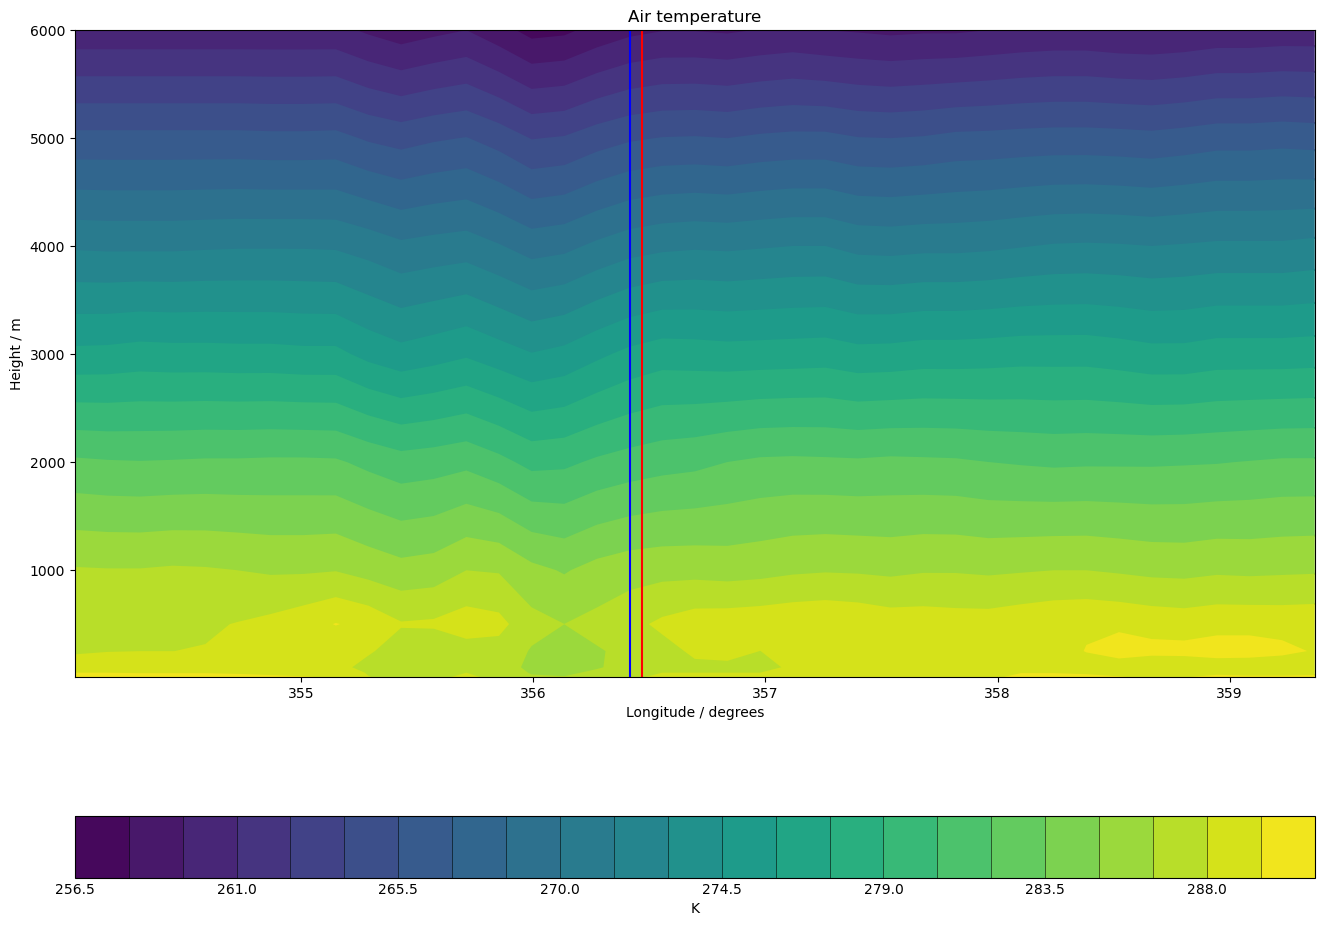

In [33]:
# plot out height cube with desired longitude and closest actual longitude
plt.figure(figsize=(16, 12))
# height profile of that red line
qplt.contourf(height_profile_of_cube, levels=30)

plt.axvline(x=desired_lon_positive, color="r", linestyle="-")  # exeter line again
# closest actual value in data
plt.axvline(x=closest_lon_val, color="b", linestyle="-")
plt.show()

#### Plot of Actual Datapoint in Gridded Data

##### Height Profile

Existing heights: [  10.   50.  100.  250.  500. 1000. 2000. 3000. 4000. 5000. 6000.]
Existing longitudes: [354.023438 354.164063 354.304688 354.445313 354.585938 354.726563
 354.867188 355.007813 355.148438 355.289063 355.429688 355.570313
 355.710938 355.851563 355.992188 356.132813 356.273438 356.414063
 356.554688 356.695313 356.835938 356.976563 357.117188 357.257813
 357.398438 357.539063 357.679688 357.820313 357.960938 358.101563
 358.242188 358.382813 358.523438 358.664063 358.804688 358.945313
 359.085938 359.226563 359.367188]


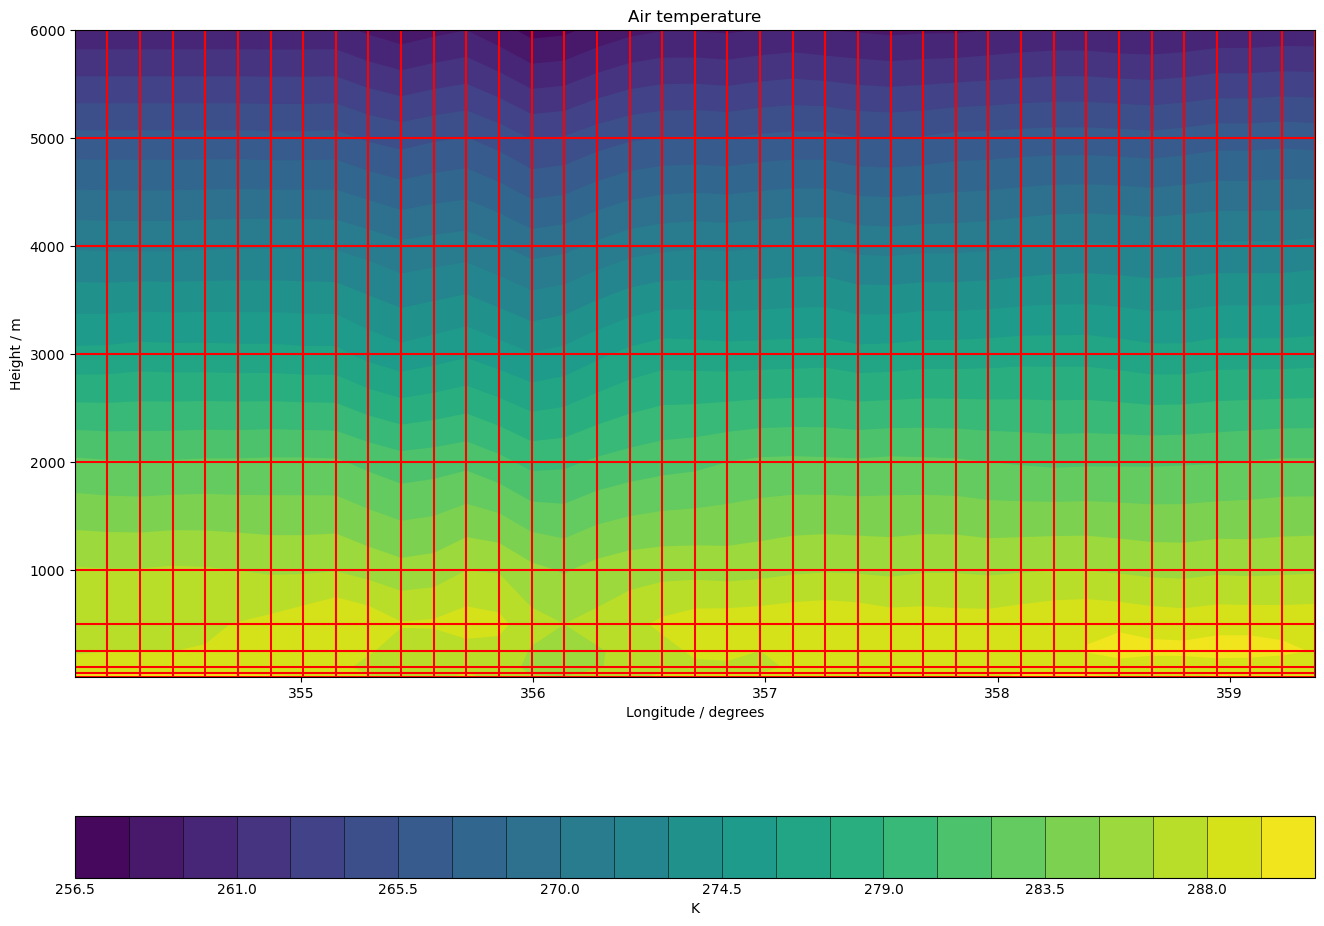

In [34]:
# show all of the actual data points that exist in the height profile
heights = height_profile_of_cube.coord("height").points
longs = height_profile_of_cube.coord("longitude").points

print("Existing heights:", heights)
print("Existing longitudes:", longs)

plt.figure(figsize=(16, 12))
qplt.contourf(height_profile_of_cube, levels=30)
for i in range(len(heights)):
    plt.axhline(y=heights[i], color="r", linestyle="-")
for i in range(len(longs)):
    plt.axvline(x=longs[i], color="r", linestyle="-")

plt.show()

##### Topdown Grid Showing

Negative longs: [-5.976562 -5.835937 -5.695312 -5.554687 -5.414062 -5.273437 -5.132812
 -4.992187 -4.851562 -4.710937 -4.570312 -4.429687 -4.289062 -4.148437
 -4.007812 -3.867187 -3.726562 -3.585937 -3.445312 -3.304687 -3.164062
 -3.023437 -2.882812 -2.742187 -2.601562 -2.460937 -2.320312 -2.179687
 -2.039062 -1.898437 -1.757812 -1.617187 -1.476562 -1.335937 -1.195312
 -1.054687 -0.914062 -0.773437 -0.632812]


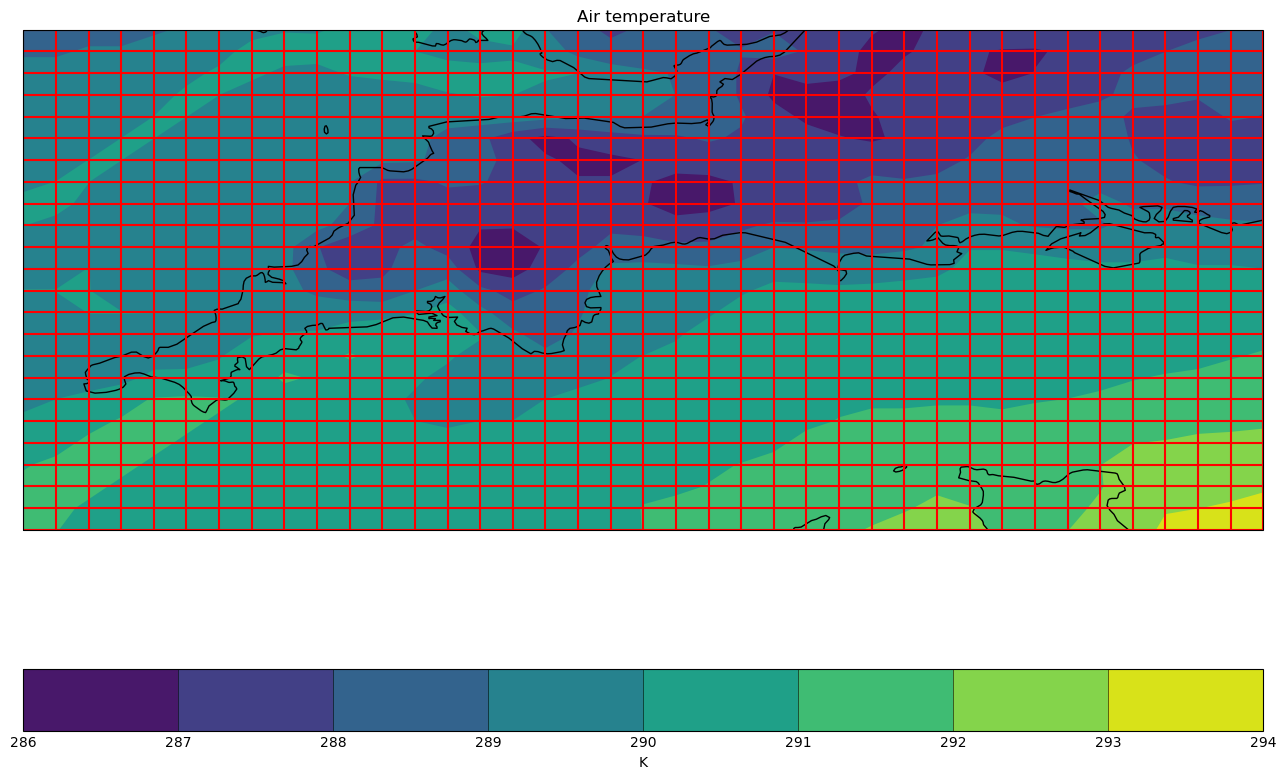

In [35]:
# do the same actual datapoint display for a top-down profile
lats = multi_layer_cube_time_0_height_0.coord("latitude").points
longs = multi_layer_cube_time_0_height_0.coord("longitude").points
longs_negative = np.add(-360, longs)
print("Negative longs:", longs_negative)
plt.figure(figsize=(16, 12))
qplt.contourf(multi_layer_cube_time_0_height_0)
plt.gca().coastlines()
for i in range(len(lats)):
    plt.axhline(y=lats[i], color="r", linestyle="-")
for i in range(len(longs_negative)):
    plt.axvline(x=longs_negative[i], color="r", linestyle="-")
plt.show()

#### Show of Temperature at a Single Datapoint (Temperature Column)

Something you might want to do is view the temperature as the height increase, we can slice a cube at a specific lon and lat to achieve this

In [36]:
# get closest datapoint to desired longitude, show the metadata of such a cube (red line on earlier height profile)
height_column = height_profile_of_cube.extract(
    iris.Constraint(longitude=closest_lon_val)
)
height_column

Air Temperature (K),height
Shape,11
Dimension coordinates,
height,x
Scalar coordinates,
forecast_period,0 hours
forecast_reference_time,2022-09-14 00:00:00
latitude,50.671875 degrees
longitude,356.414063 degrees
time,2022-09-14 00:00:00
Attributes,


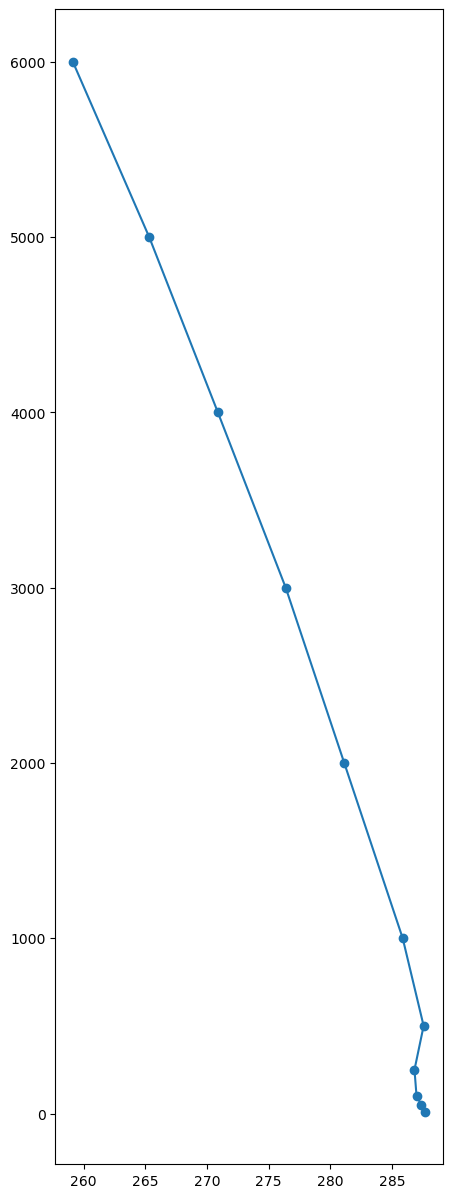

In [37]:
# plot the found temperature column
y_vals = height_column.coord("height").points
x_vals = height_column.data

fig, ax = plt.subplots(figsize=(5, 15))
ax.plot(x_vals, y_vals)
ax.scatter(x_vals, y_vals)  # also show individual points
plt.show()

### Site Specific Data Exploration

As with the previous API, to get the data, headers must be defined and given as a request to DataHub, before `cda_download.py` handled the usage of the requests package, though since the site specific data get is far less complex, interfacing with another helper file would not abstract enough of the request process for much value. The main difference is the parameters given to the https GET request that were automatically produced in the cda_downloads helper file automatically using the order information; in the site specific case, the provided parameters are the lon and lat for the desired site along with options for the returned data.

In [38]:
# hourly site specific cooridnate specifications, along with request headers
ex_lat = 50.716667
ex_lon = -3.533333

spot_data_headers = {
    "X-IBM-Client-Id": SITE_ID,
    "X-IBM-Client-Secret": SITE_SECRET,
}

params = {
    "includeLocationName": "true",
    "latitude": str(ex_lat),
    "longitude": str(ex_lon),
}

In [39]:
# request the data
request_url = "https://api-metoffice.apiconnect.ibmcloud.com/v0/forecasts/point/hourly"
request = requests.get(request_url, params=params, headers=spot_data_headers)
# insert this here otherwise IPython displays the headers of the get request
print("Request performed")

Request performed


In [40]:
# show the returned json content
content = request.json()
if SHOW_SITE_JSON_REQUEST_DATA:
    # output of this line is very large
    print("Response content:\n", json.dumps(content, indent=4))

#### Getting the Data From the Request

In order to decide how to get the data from a returned request, it is possible to either parse the API documentation on the DataHub website, or parse the actual returned JSON content (which can be optionally shown in the cell just above, with the notebook setting definition, though the output is quite large). The majority of exploration through a JSON objected involves specifying values to select specific dictionaries with keys, or list indices.

In [41]:
# get the data we want from the request return
content_forecasts = content["features"][0]["properties"]["timeSeries"]
# print(content_forecasts)

feels_like_temps = [data["feelsLikeTemperature"] for data in content_forecasts]
actual_temps = [data["screenTemperature"] for data in content_forecasts]
times = [data["time"] for data in content_forecasts]
# print(feels_like_temps)
# print(times)

#### Plot the extracted data

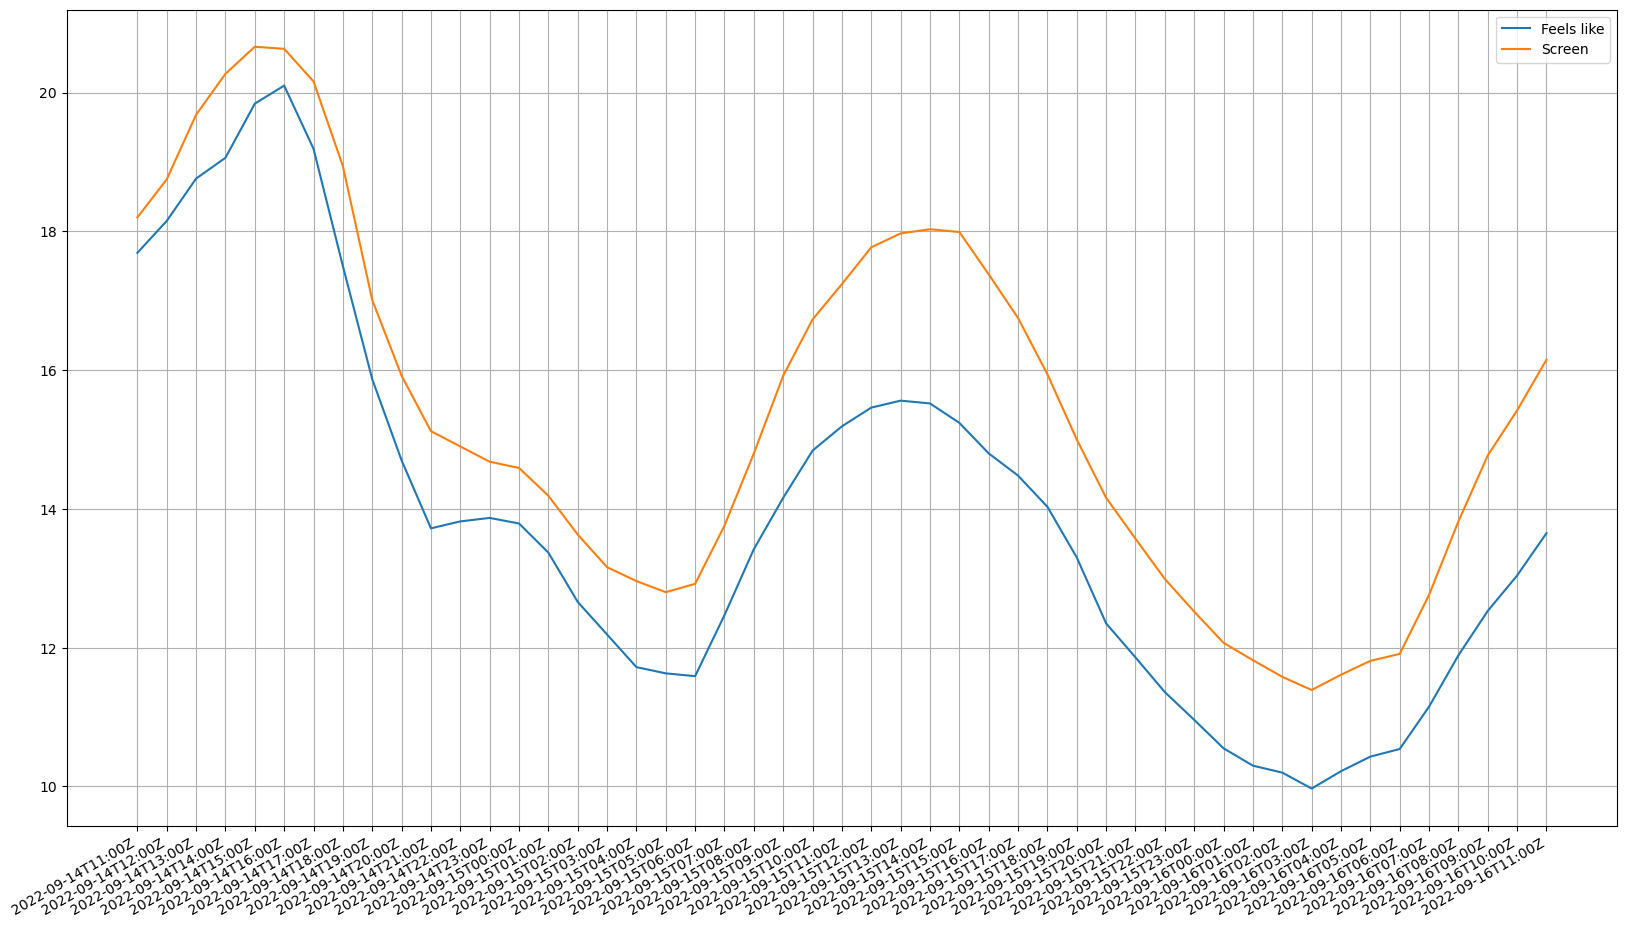

In [42]:
# plot the found data
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(times, feels_like_temps, label="Feels like")
ax.plot(times, actual_temps, label="Screen")
fig.autofmt_xdate()
plt.legend()
plt.grid()
plt.show()

---

## References


### Acknowledgements